## Imports

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Data

In [8]:
file_path = 'SpotifyFeatures.csv'
data = pd.read_csv(file_path)
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


<AxesSubplot: xlabel='genre'>

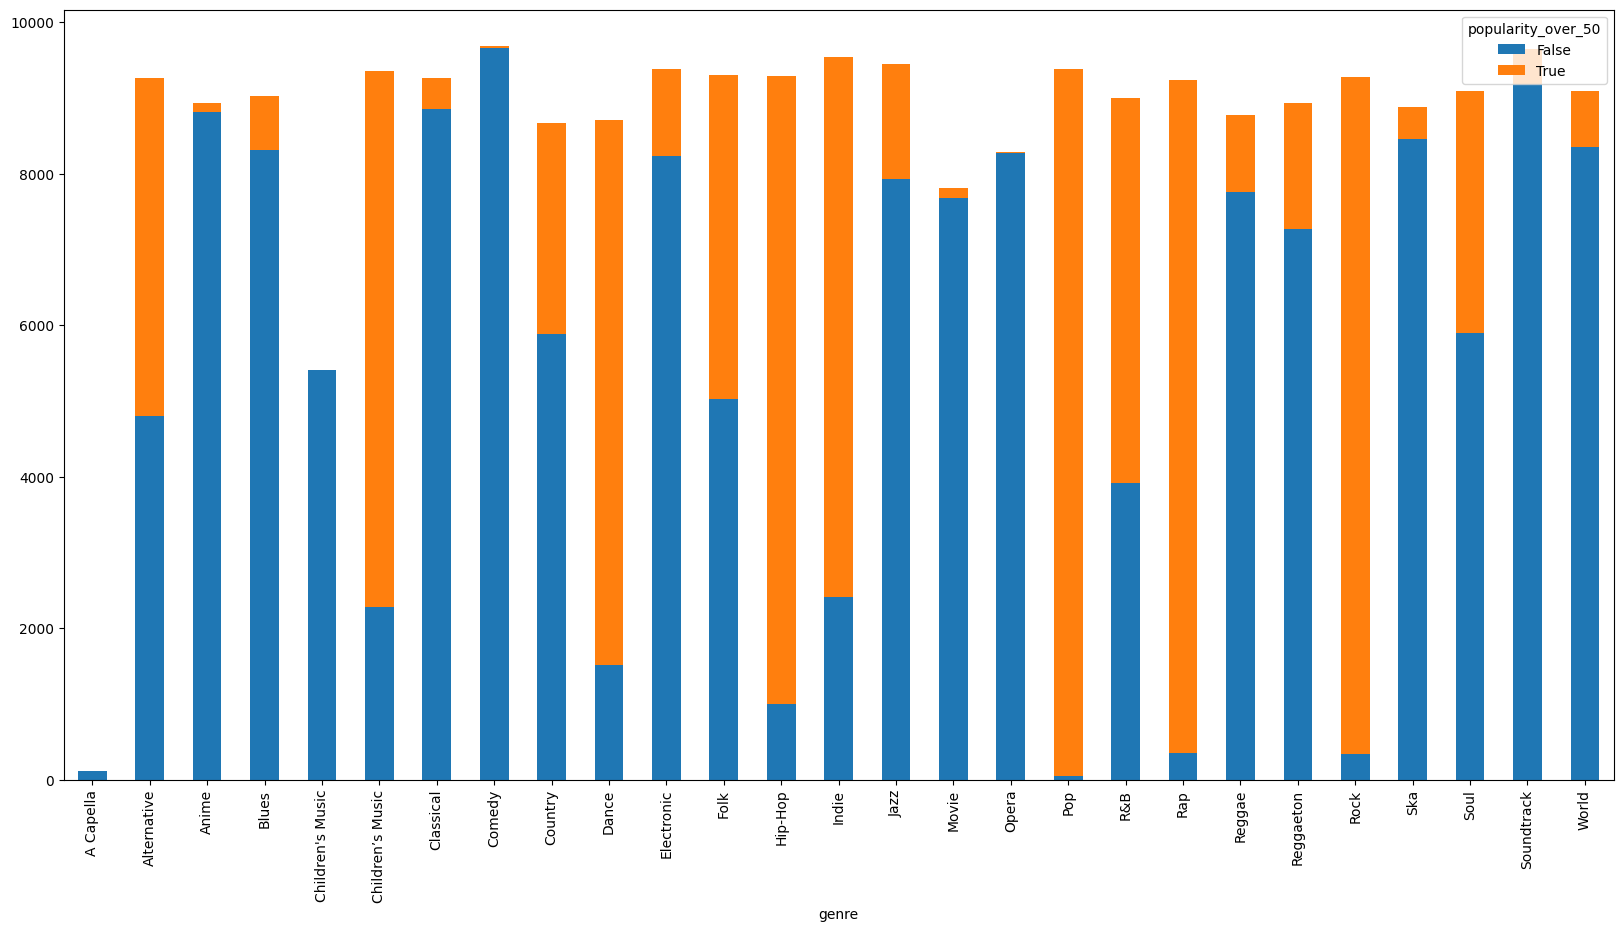

In [9]:
# split data by genre
data['genre'].unique()
data['genre'].value_counts()


# create new column for popularity over 50
data['popularity_over_50'] = data['popularity'] >= 50
data['popularity_over_50'].value_counts()

# create table graph for every genre and popularity over 50
data.groupby(['genre', 'popularity_over_50']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

#### A Capella data is too low and has to be removed.

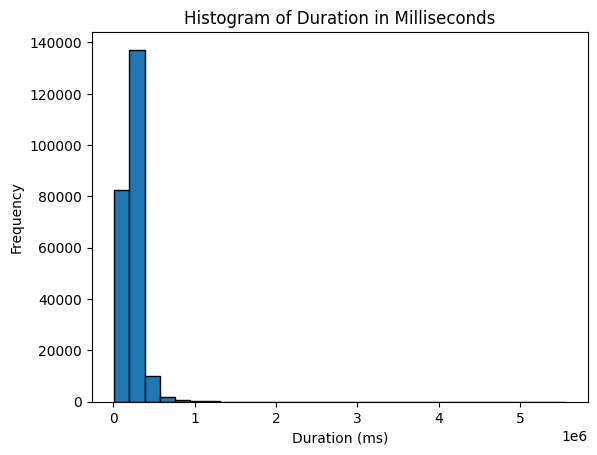

In [10]:
plt.hist(data['duration_ms'], bins=30, edgecolor='black')

# Adding labels and title
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Duration in Milliseconds')

# Displaying the plot
plt.show()

#### Removal of outliers will be done on duration_ms at 500000ms or 1 as shown in the histogram.

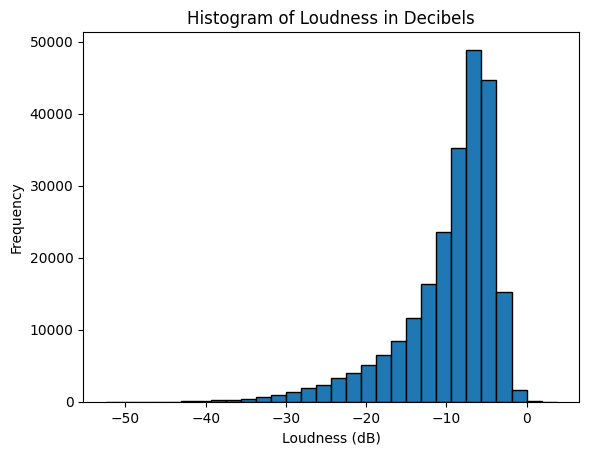

In [11]:
plt.hist(data['loudness'], bins=30, edgecolor='black')

# Adding labels and title
plt.xlabel('Loudness (dB)')
plt.ylabel('Frequency')
plt.title('Histogram of Loudness in Decibels')

# Displaying the plot
plt.show()

#### Removal of outliers will be done on loudness at 35.

In [12]:
# Print type of time_signature and mode
print(data['time_signature'].unique())
print(data['mode'].unique())


['4/4' '5/4' '3/4' '1/4' '0/4']
['Major' 'Minor']


#### Time signature and mode will be converted to integers.

## Data preprocessing

In [13]:
# Removing outliers
data = data[data['duration_ms'] < 500000]
data = data[data["loudness"] > -35]

# Add genre count column
data['genre_count'] = data.groupby('track_id')['genre'].transform('count')

# drop gernre A Capella duo to low count
data = data[data['genre'] != 'A Capella']

# Combine union child genres
data['genre'] = data['genre'].replace('Children’s Music', 'Children\'s Music')

# Convert time signature to int
data['time_signature'] = data['time_signature'].apply(lambda x: x.split('/')[0])

# Convert the mode column to 1 for major and 0 for minor
data['mode'] = data['mode'].replace("Minor", 0)
data['mode'] = data['mode'].replace("Major", 1)

In [14]:
# Function to convert pitch to number
def pitch_to_number(pitch):
    pitch_map = {
        'C': 0,
        'C#': 1, 'Db': 1,
        'D': 2,
        'D#': 3, 'Eb': 3,
        'E': 4, 'Fb': 4,
        'E#': 5, 'F': 5,
        'F#': 6, 'Gb': 6,
        'G': 7,
        'G#': 8, 'Ab': 8,
        'A': 9,
        'A#': 10, 'Bb': 10,
        'B': 11, 'Cb': 11
    }
    return pitch_map.get(pitch, None)

# Replace the pitch column with its numeric representation
data['key'] = data['key'].apply(pitch_to_number)

In [15]:
# group by genre
grouped = data.groupby('genre')

# Group by genre and calculate mean popularity
grouped = data.groupby('genre')
mean_popularity = grouped['popularity'].mean()

# Function to label rows as 'bop' or 'flop'
def label_popularity(row, mean_popularity):
    if row['popularity'] >= mean_popularity[row['genre']]:
        return 'bop'
    else:
        return 'flop'

# Apply the function to each row
data['popularity_label'] = data.apply(lambda row: label_popularity(row, mean_popularity), axis=1)

# Splitting the data into bop and flop, ensuring each genre is split 50/50
for genre in data['genre'].unique():
    genre_data = data[data['genre'] == genre]
    n = len(genre_data) // 2
    popular_indices = genre_data.nlargest(n, 'popularity').index
    nonpopular_indices = genre_data.nsmallest(n, 'popularity').index
    data.loc[popular_indices, 'popularity_label'] = 'bop'
    data.loc[nonpopular_indices, 'popularity_label'] = 'flop'

data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity_over_50,genre_count,popularity_label
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,...,0.3460,-1.828,1,0.0525,166.969,4,0.814,False,1,flop
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,...,0.1510,-5.559,0,0.0868,174.003,4,0.816,False,1,flop
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,...,0.1030,-13.879,0,0.0362,99.488,5,0.368,False,1,flop
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,...,0.0985,-12.178,1,0.0395,171.758,4,0.227,False,1,flop
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,...,0.2020,-21.150,1,0.0456,140.576,4,0.390,False,1,flop


In [16]:
# Calculate and print the size difference between nonpopular and popular for each genre
size_difference = data.groupby(['genre', 'popularity_label']).size().unstack().fillna(0)
size_difference['difference'] = size_difference['bop'] - size_difference['flop']
size_difference

popularity_label,bop,flop,difference
genre,,,
Alternative,4452,4783,-331
Anime,4293,4583,-290
Blues,4280,4491,-211
Children's Music,7355,7355,0
Classical,3860,3859,1
Comedy,4455,4689,-234
Country,4293,4358,-65
Dance,4276,4416,-140
Electronic,4424,4727,-303


<AxesSubplot: xlabel='genre'>

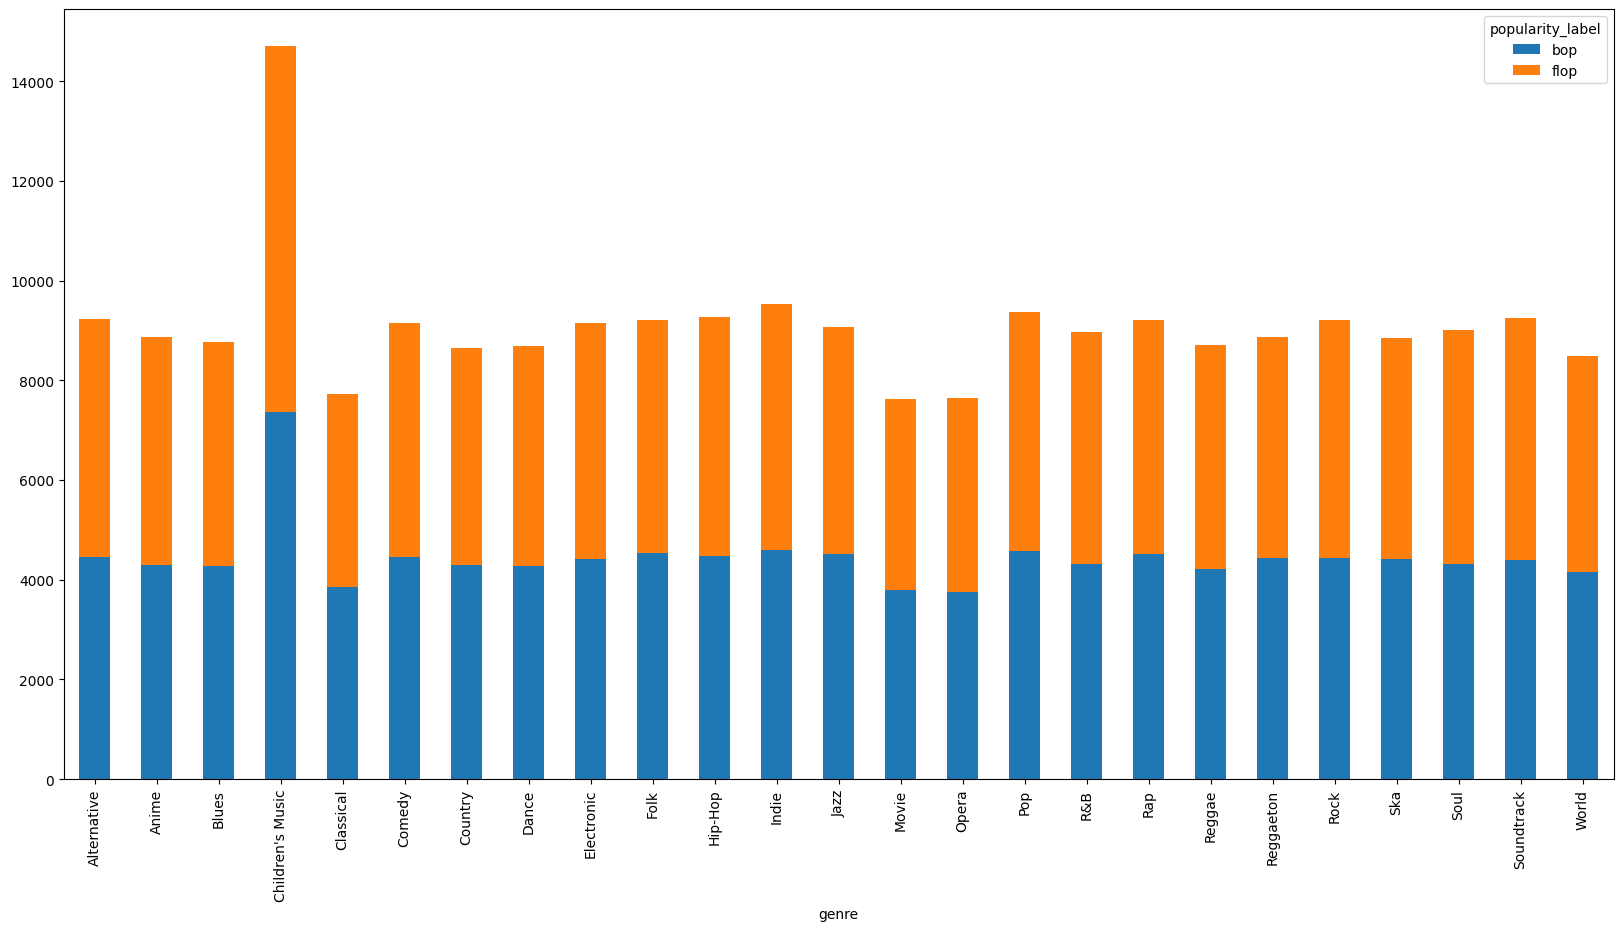

In [17]:
# grouped by genre and popularity label
data.groupby(['genre', 'popularity_label']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

In [18]:
# Splitting point (mean popularity) for every genre
splitting_points = mean_popularity.to_dict()
splitting_points

{'Alternative': 50.21418516513265,
 'Anime': 24.271631365479944,
 'Blues': 34.79808459696728,
 "Children's Music": 36.20149558123725,
 'Classical': 29.43321673791942,
 'Comedy': 21.242782152230973,
 'Country': 46.097907756328745,
 'Dance': 57.27784169351128,
 'Electronic': 38.049721341929846,
 'Folk': 49.95996962464743,
 'Hip-Hop': 58.422873773849304,
 'Indie': 54.706981627296585,
 'Jazz': 40.846451043161494,
 'Movie': 12.29021667760998,
 'Opera': 13.341054835754482,
 'Pop': 66.59140358361775,
 'R&B': 52.318956870611835,
 'Rap': 60.5366250678242,
 'Reggae': 35.60999425617461,
 'Reggaeton': 37.76805869074492,
 'Rock': 59.63577094425731,
 'Ska': 28.61764373658647,
 'Soul': 47.02853019538188,
 'Soundtrack': 33.8971972730224,
 'World': 35.55328931855694}

In [19]:
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity_over_50,genre_count,popularity_label
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,...,0.3460,-1.828,1,0.0525,166.969,4,0.814,False,1,flop
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,...,0.1510,-5.559,0,0.0868,174.003,4,0.816,False,1,flop
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,...,0.1030,-13.879,0,0.0362,99.488,5,0.368,False,1,flop
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,...,0.0985,-12.178,1,0.0395,171.758,4,0.227,False,1,flop
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,...,0.2020,-21.150,1,0.0456,140.576,4,0.390,False,1,flop


## Model

### Predicting best n_estimators

In [20]:
plot_scores = []

for n_estimator in range(1, 501, 50):
    classifiers = {}
    avg_score = 0

    for genre in data['genre'].unique():
        genre_data = data[data['genre'] == genre]
        random_seed = 1337
        X_train, X_test, y_train, y_test = train_test_split(
            genre_data[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'genre_count']], 
            genre_data['popularity_label'], 
            test_size=0.2, 
            random_state=random_seed
        )

        classifier = VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=n_estimator, random_state=random_seed)),
                ('gb', GradientBoostingClassifier(n_estimators=n_estimator, random_state=random_seed)),
                ('ab', AdaBoostClassifier(n_estimators=n_estimator, random_state=random_seed)),
                ('lr', LogisticRegression(random_state=random_seed)),
                ('svc', SVC(random_state=random_seed))
            ], 
            voting='hard'
        )

        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        classifiers[genre] = score
        avg_score += score

    avg_score /= len(data['genre'].unique())
    plot_scores.append(avg_score)

plt.plot(range(1, 501, 50), plot_scores)
plt.ylabel('Average Accuracy Score')
plt.xlabel('Number of Estimators')
plt.show()

KeyboardInterrupt: 

In [21]:

# Create a dictionary of classifiers, one for each genre, random forest classifier
classifiers = {}

# Create a classifier for each genre
for genre in data['genre'].unique():
    # Create a new DataFrame containing only the current genre
    genre_data = data[data['genre'] == genre]

    random_seed = 1337
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(genre_data[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'genre_count']], genre_data['popularity_label'], test_size=0.2, random_state=random_seed)


    
    # add more to votingClassifier
    classifier = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=random_seed)),
        ('gb', GradientBoostingClassifier(n_estimators=50, random_state=random_seed)),
        ('ab', AdaBoostClassifier(n_estimators=50, random_state=random_seed)),
        ('lr', LogisticRegression(random_state=random_seed)),
        ('svc', SVC(random_state=random_seed))  # Note: SVC doesn't have a random_state parameter in older versions
    ], 
    voting='hard'
    )

    # Train the classifier
    classifier.fit(X_train, y_train)
    # Add the classifier to the dictionary of classifiers
    classifiers[genre] = classifier

    # add accuracy score to dictionary
    classifiers[genre] = classifier.score(X_test, y_test)
    print("genre: ", genre, " Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
    print("genre: ", genre, " Accuracy score (validation): {0:.3f}".format(classifier.score(X_test, y_test)))

    

# Print the dictionary of classifiers
classifiers

KeyboardInterrupt: 

In [ ]:

# Creating a bar chart
plt.figure(figsize=(12, 8))
plt.bar(classifiers.keys(), classifiers.values(), color='skyblue')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Accuracy Score', fontsize=14)
plt.title('Accuracy of Ensemble Model by Genre', fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# print avg accuracy score
avg = 0
for genre in classifiers:
    avg += classifiers[genre]
avg /= len(classifiers)
print(avg)
